In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
import sklearn
import random
import autosklearn.regression
from tdc.chem_utils import MolConvert

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


from tqdm.notebook import tqdm

In [2]:
def snr_distance(ri, rj):
    return np.var(ri - rj) / (np.var(ri) + 1e-8)

In [3]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [4]:
df = pd.read_csv('../data/arylhalide_database_w_idx_min5.csv')
df

,RxnSMILES,Arylhalide,Canonical,RxnID,Yield,ScopeID,ScopeSize,aroma_c_index,halide_index
0,C[Si](C)(C)[Si:1]([CH3:2])([CH3:3])[CH3:4].I[C...,I[C:11]1=[CH:9][CH:7]=[C:6]([Cl:5])[CH:8]=[CH:...,Clc1ccc(I)cc1,12980746,67.0,9,10,1,0
1,C[Si](C)(C)[Si:9]([CH3:10])([CH3:11])[CH3:12]....,I[C:6]1=[CH:4][C:2]([Cl:1])=[CH:3][C:5]([Cl:7]...,Clc1cc(Cl)cc(I)c1,12980747,65.0,9,10,1,0
2,C[Si](C)(C)[Si:11]([CH3:12])([CH3:13])[CH3:14]...,I[C:10]1=[CH:8][CH:6]=[C:5]([C:1]([CH3:2])([CH...,CC(C)(C)c1ccc(I)cc1,12980741,71.0,9,10,1,0
3,C[Si](C)(C)[Si:1]([CH3:2])([CH3:3])[CH3:4].I[C...,I[C:11]1=[CH:9][CH:7]=[C:6]([F:5])[CH:8]=[CH:10]1,Fc1ccc(I)cc1,12980744,74.0,9,10,1,0
4,C[Si](C)(C)[Si:9]([CH3:10])([CH3:11])[CH3:12]....,I[C:6]1=[CH:4][C:2]([CH3:1])=[CH:3][C:5]([CH3:...,Cc1cc(C)cc(I)c1,12980740,77.0,9,10,1,0
...,...,...,...,...,...,...,...,...,...
64187,Br[C:1]1=[CH:2][C:4]2=[C:6]([CH:5]=[CH:3]1)[CH...,Br[C:1]1=[CH:2][C:4]2=[C:6]([CH:5]=[CH:3]1)[CH...,Brc1ccc2ccccc2c1,22184995,77.0,633578,7,1,0
64188,Br[C:1]1=[CH:3][CH:5]=[C:7]2[C:4](=[CH:2]1)[C:...,Br[C:1]1=[CH:3][CH:5]=[C:7]2[C:4](=[CH:2]1)[C:...,Brc1ccc2sc3ccccc3c2c1,21838100,73.0,633578,7,1,0
64189,Br[C:19]1=[CH:17][CH:15]=[C:14]([O:12][CH3:13]...,Br[C:19]1=[CH:17][CH:15]=[C:14]([O:12][CH3:13]...,COc1ccc(Br)cc1,22185457,74.0,633578,7,1,0
64190,Br[C:1]1=[CH:2][C:4]2=[C:6]([CH:5]=[CH:3]1)[CH...,Br[C:1]1=[CH:2][C:4]2=[C:6]([CH:5]=[CH:3]1)[CH...,Brc1ccc2ccccc2c1,22185449,77.0,633578,7,1,0


In [5]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/arylhalide_database_w_idx_min5.csv"))

train_dataset = [smiles_to_graph_substrate(smiles=data['Arylhalide'][ind], 
                                        s=data['ScopeID'][ind], 
                                        y=data['Yield'][ind]/100, 
                                            atm_idx=[data['aroma_c_index'][ind]]) for ind in range(len(data))]


# train_dataset = torch.load(os.path.join(HOME_DIR, "data/train_dataset.ptg"))
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)

In [6]:
converter = MolConvert(src = 'SMILES', dst = 'RDKit2D')
rdkit2d_features = converter(data['Canonical'].tolist())

In [7]:
# scope_list = [9, 422, 426, 633347, 633384, 633578]
scope_list = df['ScopeID'].unique()

r2_dict = {}

for scope in tqdm(scope_list):
    # leave-one-out validation on scope
    temp = df[df['ScopeID'] == scope]
    if len(temp) < 5:
        pass
    else:
        X = embeddings_pretrained[temp.index]
        y = temp.Yield.values
        loo = LeaveOneOut()
        y_pred = np.zeros_like(y)
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric=snr_distance).fit(X_train, y_train)
            y_pred[test_index] = reg.predict(X_test)
        r2_dict[scope] = r2_score(y, y_pred)


  0%|          | 0/6919 [00:00<?, ?it/s]

In [8]:
# scope_list = [9, 422, 426, 633347, 633384, 633578]
scope_list = df['ScopeID'].unique()

r2_rdkit_dict = {}

for scope in tqdm(scope_list):
    # leave-one-out validation on scope
    temp = df[df['ScopeID'] == scope]
    if len(temp) < 5:
        pass
    else:
        X = rdkit2d_features[temp.index]
        y = temp.Yield.values
        loo = LeaveOneOut()
        y_pred = np.zeros_like(y)
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            reg = RandomForestRegressor(n_estimators=5, max_depth=5).fit(X_train, y_train)
            y_pred[test_index] = reg.predict(X_test)
        r2_rdkit_dict[scope] = r2_score(y, y_pred)


  0%|          | 0/6919 [00:00<?, ?it/s]

In [9]:
# scope_list = [9, 422, 426, 633347, 633384, 633578]
scope_list = df['ScopeID'].unique()

r2_rdkit_knn_dict = {}

for scope in tqdm(scope_list):
    # leave-one-out validation on scope
    temp = df[df['ScopeID'] == scope]
    if len(temp) < 5:
        pass
    else:
        X = rdkit2d_features[temp.index]
        y = temp.Yield.values
        loo = LeaveOneOut()
        y_pred = np.zeros_like(y)
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]
            reg = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='l1').fit(X_train, y_train)
            y_pred[test_index] = reg.predict(X_test)
        r2_rdkit_knn_dict[scope] = r2_score(y, y_pred)

  0%|          | 0/6919 [00:00<?, ?it/s]

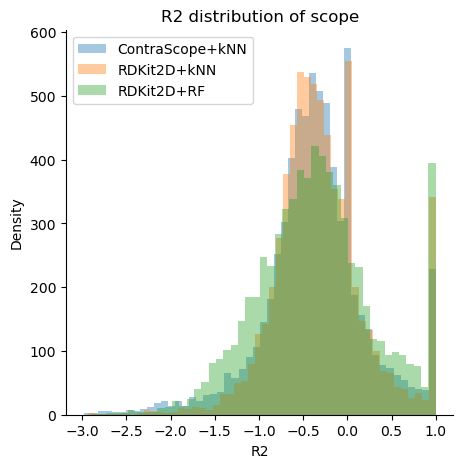

In [13]:
f, ax = plt.subplots(figsize=(5, 5))
sns.distplot(list(r2_dict.values()), kde=False, ax=ax, label='ContraScope+kNN')
sns.distplot(list(r2_rdkit_knn_dict.values()), kde=False, ax=ax, label='RDKit2D+kNN')
sns.distplot(list(r2_rdkit_dict.values()), kde=False, ax=ax, label='RDKit2D+RF')
ax.set_xlabel('R2')
ax.set_ylabel('Density')
ax.set_title('R2 distribution of scope')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
# plt.show()
plt.savefig('cas_r2_dist.png', dpi=300, bbox_inches='tight')